# Signal vs. background classification in NEXT

In [1]:
%matplotlib inline

import os
import h5py
import matplotlib        as mpl
import matplotlib.pyplot as plt
import numpy             as np
import tables            as tb
import pandas            as pd

from glob                import glob
from matplotlib.patches  import Ellipse

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.autograd import Function
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

mpl.rcParams.update({'font.size': 14})

#### Enable/disable CUDA

In [2]:
CUDA_enabled = False
if(CUDA_enabled):
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## Definition of key variables
The directory structure followed is:

`$NEXTHOME/data`   -- contains datafiles `signal.h5` and `background.h5`<br>
`$NEXTHOME/models` -- contains saved models

In [3]:
# data dimensions
xdim = 20
ydim = 20
zdim = 60

# directory structure
basedir = os.environ['NEXTHOME']
datadir = f"{basedir}/data"
modelsdir = f"{basedir}/models"

datafile_signal = f"{datadir}/signal.h5"
datafile_background = f"{datadir}/background.h5"

## Preview events
The events are 20x20x60 maps of simulated voxelized tracks. One can get a good idea of what these tracks look like by summing over the z-dimension and plotting this projection in x-y.

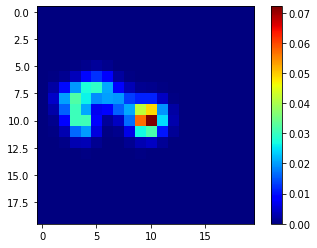

In [4]:
evtnum = 5
fn = tb.open_file(datafile_background,'r')
evt = fn.root.maps[evtnum]
plt.imshow(np.sum(evt,axis=2),cmap='jet')
plt.colorbar()

## Data preparation
Here a Pytorch `Dataset` is created for batching 3D maps of NEXT track topologies. The files containing signal and background events are provided, followed by a range of events. The idea is that the training, validation, and test sets can be created using events from the same files via differing ranges of events. The flag `load_to_memory`, when set to `True`, loads all events into memory at once for faster batching.

In [5]:
class NEXTDataset(Dataset):
    def __init__(self, datafile_signal, datafile_background, nstart=0, nend=0, load_to_memory=True):
        
        # Save inputs for later use.
        self.datafile_signal     = datafile_signal
        self.datafile_background = datafile_background
        self.load_to_memory = load_to_memory
        
        # Get the number of signal and background events.
        fsignal = tb.open_file(datafile_signal,'r')
        nsignal = len(fsignal.root.maps)
        fbackground = tb.open_file(datafile_background,'r')
        nbackground = len(fbackground.root.maps)
        
        # Ensure we have the same number of total signal and background events.
        nmin = min(nsignal,nbackground)
        
        # Ensure nend > nstart.
        if(nend <= nstart):
            nend = nmin
            
        # Load everything at once.
        if(load_to_memory):
            self.data = np.concatenate([np.array(fsignal.root.maps[nstart:nend]),np.array(fbackground.root.maps[nstart:nend])],axis=0)
            self.lbls = np.concatenate([np.ones([nend-nstart,1]),np.zeros([nend-nstart,1])],axis=0)
        
        # Save the final values of nstart and nend.
        self.nstart = nstart
        self.nend   = nend
        
        fsignal.close()
        fbackground.close()
        print("Created dataset from events",nstart,"to",nend,"of",nmin,"available signal and background events")

    def __len__(self):
        return 2*(self.nend-self.nstart)

    def __getitem__(self, idx):
        
        # Choose the data,label pair at the specified index if everything is already loaded into memory.
        if(self.load_to_memory):
            evt = torch.tensor(self.data[idx]).float()
            lbl = torch.tensor(self.lbls[idx]).float()
        
        # Otherwise find the event in the correct file.
        else:
            # Second half of indices correspond to background.
            nrange = (self.nend-self.nstart)
            if(idx >= nrange):
                datafile = self.datafile_background
                idx -= nrange
                lbl = torch.tensor([0]).float()
            else:
                datafile = self.datafile_signal
                lbl = torch.tensor([1]).float()

            # Open the correct file and extract the element corresponding to this index.
            f = tb.open_file(datafile,'r')
            evt = torch.tensor(np.array(f.root.maps[idx])).float()
            f.close()
        
        if(CUDA_enabled):
            return evt.cuda(),lbl.cuda()
        else:
            return evt,lbl

## Create a neural network
Here the neural network architecture is defined.

In [6]:
class FCNet(nn.Module):

    def __init__(self):
        super(FCNet, self).__init__()
        self.fc1 = nn.Linear(xdim*ydim*zdim, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x.reshape(-1,xdim*ydim*zdim)))
        x = self.fc2(x)
        return x

## Train the network
Here functions for network training and validation are defined.

In [7]:
verbose = False

def train(model,epoch):
    losses_epoch = []
    for batch_idx, (data, target) in enumerate(train_loader):
        
        if(CUDA_enabled):
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()

        # Compute the model result.
        output_score = model(data)
        
        # Compute the loss: note BCEWithLogitsLoss performs a sigmoid followed by binary cross entropy.
        m = torch.nn.BCEWithLogitsLoss()
        loss = m(output_score,target)
        
        loss.backward()
        optimizer.step()

        if verbose and (batch_idx % 10 == 0):
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t logits_max: {:.6f}\t logits_min: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item(), 
                output_score[:,0].data.max(), output_score[:,0].data.min()))
            
        losses_epoch.append(loss.data.item())
        
    print("---EPOCH",epoch,"AVG TRAIN LOSS:",np.mean(losses_epoch))

def val(model,epoch):
    losses_epoch = []
    for batch_idx, (data, target) in enumerate(val_loader):
        
        if(CUDA_enabled):
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)

        # Compute the model result.
        output_score = model(data)
        
        # Compute the loss.
        m = torch.nn.BCEWithLogitsLoss()
        loss = m(output_score,target)
        
        if verbose and (batch_idx % 10 == 0):
            print('--Val Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t logits_max: {:.6f}\t logits_min: {:.6f}'.format(
                epoch, batch_idx * len(data), len(val_loader.dataset),
                100. * batch_idx / len(val_loader), loss.data.item(), 
                output_score[:,0].data.max(), output_score[:,0].data.min()))
        losses_epoch.append(loss.data.item())
        
    print("---EPOCH",epoch,"AVG VAL LOSS:",np.mean(losses_epoch))

Create datasets and data loaders for training and validation.

In [8]:
dataset_train = NEXTDataset(datafile_signal, datafile_background, 0, 5000)
train_loader  = DataLoader(dataset_train, batch_size=200, shuffle=True)

dataset_val   = NEXTDataset(datafile_signal, datafile_background, 5000, 6000)
val_loader    = DataLoader(dataset_val, batch_size=200, shuffle=True)

Created dataset from events 0 to 5000 of 89544 available signal and background events
Created dataset from events 5000 to 6000 of 89544 available signal and background events


Set some key flags for training:
- **load_model**: set to True to load the specified model. If training is True, the model will be loaded before any training begins.
- **modelfile**: the model to be loaded
- **training**: set to True to perform training
- **lrate**: the learning rate to use for training

Note: to perform testing with an already trained model, set `load_model` to `True` and `training` to `False`.

In [9]:
lrate = 1e-2
load_model = False
training = True
modelfile = f"{modelsdir}/model_NEXT_0.pt"

In [ ]:
# Define the model.
model = FCNet()
if(CUDA_enabled):
    model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lrate, betas=(0.9, 0.999), eps=1e-6, weight_decay=0)

# Load the model from file.
if(load_model):
    model.load_state_dict(torch.load(modelfile))
    model.eval()

# Train the model.
if(training):
    for epoch in range(0, 100):
        print("\nEpoch: ",epoch)
        model.train()
        train(model,epoch)
        with torch.no_grad():
            model.eval()
            val(model,epoch)
        torch.save(model.state_dict(), f"{modelsdir}/model_NEXT_{epoch}.pt")

## Test the model
Create a test dataset and loader

In [11]:
dataset_test  = NEXTDataset(datafile_signal, datafile_background, 8000, 10000)
test_loader   = DataLoader(dataset_test, batch_size=200, shuffle=True)

Created dataset from events 8000 to 10000 of 89544 available signal and background events


Run the model (in batches) on each data sample.

In [12]:
sig = nn.Sigmoid()
model.eval()

all_cls, all_tgt = np.array([]), np.array([])
test_iter = iter(test_loader)
for (data,tgt) in test_iter:
    
    # Get the classification for this batch.
    if(CUDA_enabled):
        data_cuda = data.cuda()
        cls_gpu = sig(model(data_cuda))
        cls = np.array(cls_gpu.cpu().detach().squeeze())
    else:
        cls = np.array(sig(model(data)).detach().squeeze())
 
    # Convert the target to numpy format.
    tgt = np.array(tgt.cpu().squeeze())
    
    all_cls = np.concatenate([all_cls,cls],axis=0)
    all_tgt = np.concatenate([all_tgt,tgt],axis=0)

Compute the signal efficiency vs. background rejection for several thresholds.
- the **signal efficiency** is the number of correctly predicted (prediction >= threshold) signal events divided by the total number of signal events
- the **background rejection** is the number of correctly predicted (prediction < threshold) background events divided by the total number of background events

In [13]:
npoints = 100
signal_eff, background_rej = [],[]
for th in np.arange(0,1,1./npoints):
    
    # Get the total number of each class.
    total_signal     = np.sum(all_tgt)
    total_background = len(all_tgt) - total_signal
    
    # Get the number of correctly classified for each class.
    correct_signal     = np.sum(all_cls[all_tgt == 1] >= th)
    correct_background = np.sum(all_cls[all_tgt == 0] < th)
    
    signal_eff.append(1.0*correct_signal/total_signal)
    background_rej.append(1.0*correct_background/total_background)

Plot the results.

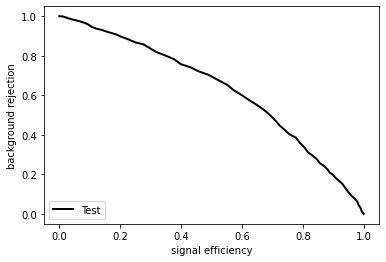

In [14]:
plt.plot(signal_eff,background_rej,color='black',label='Test',lw=2)
plt.xlabel("signal efficiency")
plt.ylabel("background rejection")
plt.legend(loc=3)

## Things to try:
1. Design an improved network.
2. Evaluate individual events: plot the event along with its classification probability. Is this how you would have classified the event? 